## Библиотеки

In [1]:
# работа с файлами (ETL)
import sys
import os
from pathlib import Path

# работа с данными (DQC & ETL)
import numpy as np
# np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pyxlsb
import scipy

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Чтение данных

In [2]:
%%time
# get directory path
dirpath = os.getcwd()
raw_data_path = Path(dirpath) / 'raw_data'

# load data to dict
data = {}
for file_path in raw_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_excel(file_path)
        print(file_path.stem, data[file_path.stem].shape)

Test (38405, 26)
Training (89734, 26)
CPU times: total: 26.1 s
Wall time: 26.5 s


In [3]:
data['Training'].head(1)

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.198778,0.099389,0.0,799.9,1.777556,0.888778,13,3.49,Woman,33.75,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0


Размер данных соответствует количеству записей в файлах Excel — данные полностью считываются и в правильных форматах.

## Проверка & исследование наполнения данных (контента)

In [4]:
def check_content(data):
    data_info = []
    for df_name, df in data.items():
        # drop ID
        if 'ID' in df.columns:
            df.drop(['ID'], axis=1, inplace=True)
        # proccesing columns with small number of unique
        low_unique = pd.Series()
        low_unique_cols = df.columns[df.apply(pd.Series.nunique) < 15].tolist()
        for idx, col in enumerate(df.columns):
            if col in low_unique_cols:
                low_unique.at[idx] = df[col].unique()
            else:
                low_unique.at[idx] = '-'
        # build table with info
        data_info.append(
            pd.DataFrame(
                data=[(df.isna().sum(0)).values,
                      df.nunique().values,
                      df.dtypes,
                      [len(df) for _ in range(len(df.columns))],
                      low_unique
                     ],
                index=['nans', 'unique', 'dtype', 'total', 'low_unique_values'],
                columns= pd.MultiIndex.from_tuples([(col, df_name) for col in df.columns], names=["column_name", "table_name"])
            )
        )
    return pd.concat(data_info, axis=1).transpose().reset_index().set_index(["table_name", "column_name"])

In [5]:
check_content(data)

nans unique    dtype  total                                                                                                                                  low_unique_values
table_name column_name                                                                                                                                                                               
Test       A              0  25119  float64  38405                                                                                                                                                  -
           B              0  29087  float64  38405                                                                                                                                                  -
           C              0   7331  float64  38405                                                                                                                                                  -
           D              0   9445  float64  38405                                                                                                                                                  -
           E              0  26191  float64  38405                                                                                                                                                  -
           F              0  29959  float64  38405                                                                                                                                                  -
           G              0     11    int64  38405                                                                                                             [13, 24, 10, 2, 5, 4, 9, 6, 11, 3, 20]
           H              0     13  float64  38405                                                                         [3.49, 1.99, 2.49, 0.01, 3.5, 3.0, 2.99, 0.0, 1.235, 1.1, 1.17, 1.32, 2.5]
           I              0      2   object  38405                                                                                                                                       [Woman, Man]
           J              0    528  float64  38405                                                                                                                                                  -
           K              0      7   object  38405                                                   [Minsk region, Vitebsk region, Gomel region, Grodno region, Brest region, Mogilev region, Minsk]
           L              0    484    int64  38405                                                                                                                                                  -
           M              0      5   object  38405                                                   [NE employee, Head/Deputy head (division), Head/Deputy head (organiz.), Pensioner, Enterpreneur]
           N              0      4   object  38405  [Secondary education (plus special education), Higher education (one or more), Incomplete higher education, Primary or lower secondary education]
           O              0      4   object  38405                                                                                          [Single/unmarried, Married, Cohabitation, Divorced/widow]
           P              0      5   object  38405                                                                                                       [1 One, 3 Three, 0 Zero, 2 Two, More than 3]
           Q              0      3   object  38405                                                                                                                   [property, otherwise, rent/hire]
           R              0      2   object  38405                                                                                                                                          [No, Yes]
           S              0      5   object  38405             

In [6]:
data['Training'].loc[:, ~(data['Training']).columns.isin(['ID', 'MARKER'])].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,A,B,C,D,E,F,G,H,J,L
count,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000,89734.000000
mean,0.167863,0.113511,85.801266,548.507954,1.011455,0.683640,7.854358,0.510274,41.140778,103.719092
std,0.153851,0.105340,105.366771,448.686233,0.910583,0.622047,4.754588,0.928146,11.129976,100.458022
min,0.000002,0.000001,0.000000,49.980000,0.000016,0.000012,2.000000,0.000000,21.000000,0.000000
1%,0.016246,0.010292,0.000000,62.920000,0.096527,0.060968,2.000000,0.000000,22.083333,3.000000
5%,0.029328,0.018875,0.000000,107.825500,0.175493,0.111995,2.000000,0.000000,24.500000,6.000000
25%,0.065843,0.042922,20.570000,227.030000,0.405983,0.263775,4.000000,0.000000,32.083333,29.000000
50%,0.119133,0.079733,50.020000,408.735000,0.749403,0.499387,5.000000,0.000000,40.000000,69.000000
75%,0.220000,0.146990,108.930000,746.710000,1.333367,0.899260,13.000000,0.010000,50.000000,144.000000
95%,0.468460,0.325408,297.470000,1425.000000,2.700075,1.871499,13.000000,2.490000,60.166667,324.000000


* У нас есть чистые данные (без NaN)
* Много столбцов с типом объекта (строки) содержат небольшое количество уникальных значений (за исключением G и F)
* Численные признаки G, H, L скорее всего дискретные
* Малоинформативных признаков (малая дисперсия при соответствующих больших величинах) не наблюдается

## Переименование колонок

In [7]:
def rename_columns(data):
    for df_name, df in data.items():
        
        # численные признаки
        numeric_cols = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['MARKER']))].tolist()
        numeric_names = [f'numeric{i}' for i in range(1, len(numeric_cols)+1)]
        numeric_dict = {old_name: new_name for old_name, new_name in zip(numeric_cols, numeric_names)}
   
        # # строковые признаки
        # string_cols = df.columns[(df.dtypes == 'object') & (~df.columns.isin(['MARKER']))].tolist()
        # string_names = [f'string{i}' for i in range(1, len(string_cols)+1)]
        # string_dict = {old_name: new_name for old_name, new_name in zip(string_cols, string_names)}

        # булевые признаки (Yes/No)
        bool_cols = df.columns[df.apply(lambda x: x.isin(['Yes', 'No']).all())].tolist()
        bool_names = [f'boolean{i}' for i in range(1, len(bool_cols)+1)]
        bool_dict = {old_name: new_name for old_name, new_name in zip(bool_cols, bool_names)}
        
        # rename string columns 
        string_dict = {'K':'Region', 'I':'Sex', 'S':'Work status', 'N':'Education',
                        'O':'Family status', 'Q': 'Real property', 'M': 'Employment type'}
        
        d = {**numeric_dict, **string_dict, **bool_dict}
        df.rename(columns=d, inplace=True)

In [8]:
rename_columns(data)

In [9]:
data['Training'].columns

Index(['numeric1', 'numeric2', 'numeric3', 'numeric4', 'numeric5', 'numeric6', 'numeric7', 'numeric8', 'Sex', 'numeric9', 'Region', 'numeric10', 'Employment type', 'Education', 'Family status', 'P', 'Real property', 'boolean1', 'Work status', 'boolean2', 'boolean3', 'V', 'boolean4', 'boolean5', 'MARKER'], dtype='object')

* Переименование столбцов для упрощения исследовательского анализа данных и инженерии признаков.

## Чистка выбросов

In [10]:
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [11]:
# simple filter
# def remove_outliers(data):
#     for df_name, df in data.items():
#         numeric_cols = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['MARKER']))].tolist()
#         df[numeric_cols] = df[numeric_cols][(np.abs(scipy.stats.zscore(df[numeric_cols])) < 3).all(axis=1)]
#         df.dropna(inplace=True)

In [12]:
def remove_outliers(df, numeric_col):
    df['zscore'] = zscore(df[numeric_col])
    df = df[np.abs(df['zscore']) < 3]
    df.drop(columns=['zscore'], inplace=True)
    return df

def remove_outliers_visualization(data):
    for df_name, df in data.items():
        numeric_cols = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['MARKER']))].tolist()
        
        for numeric_col in numeric_cols:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            plt.subplots_adjust(wspace=0.4)
            
            # боксплоты до очистки
            sns.boxplot(x=df['MARKER'], y=df[numeric_col], ax=axes[0])
            axes[0].set_title(f'Before Outlier Removal - {numeric_col}')
            
            # Фильтрация выбросов по числовым колонкам
            df_filtered = df.groupby('MARKER').apply(lambda group: remove_outliers(group, numeric_col)).reset_index(drop=True)
            
            # Обновление данных в словаре data
            data[df_name] = df_filtered
            
            # боксплоты после фильтрации
            sns.boxplot(x=df_filtered['MARKER'], y=df_filtered[numeric_col], ax=axes[1])
            axes[1].set_title(f'After Outlier Removal - {numeric_col}')
            
            plt.tight_layout()
            plt.show()

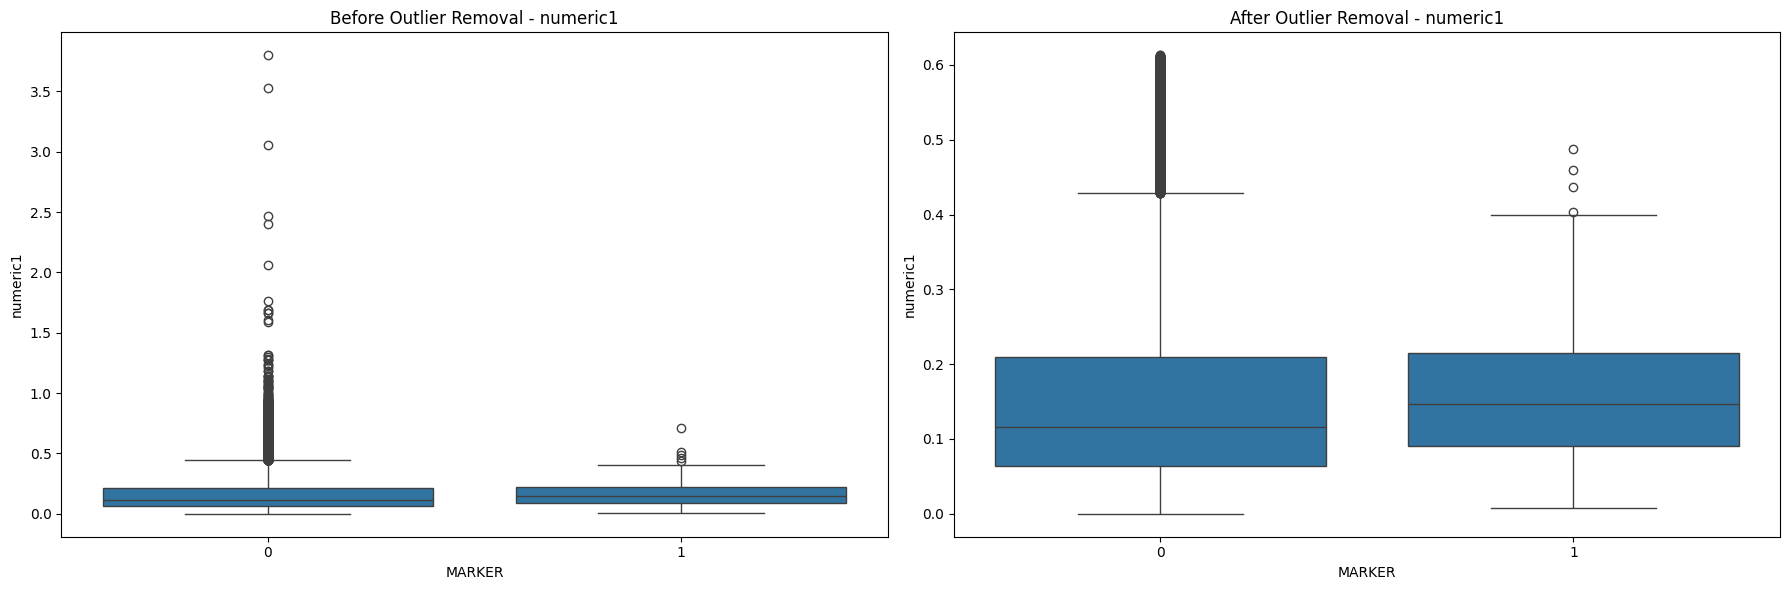

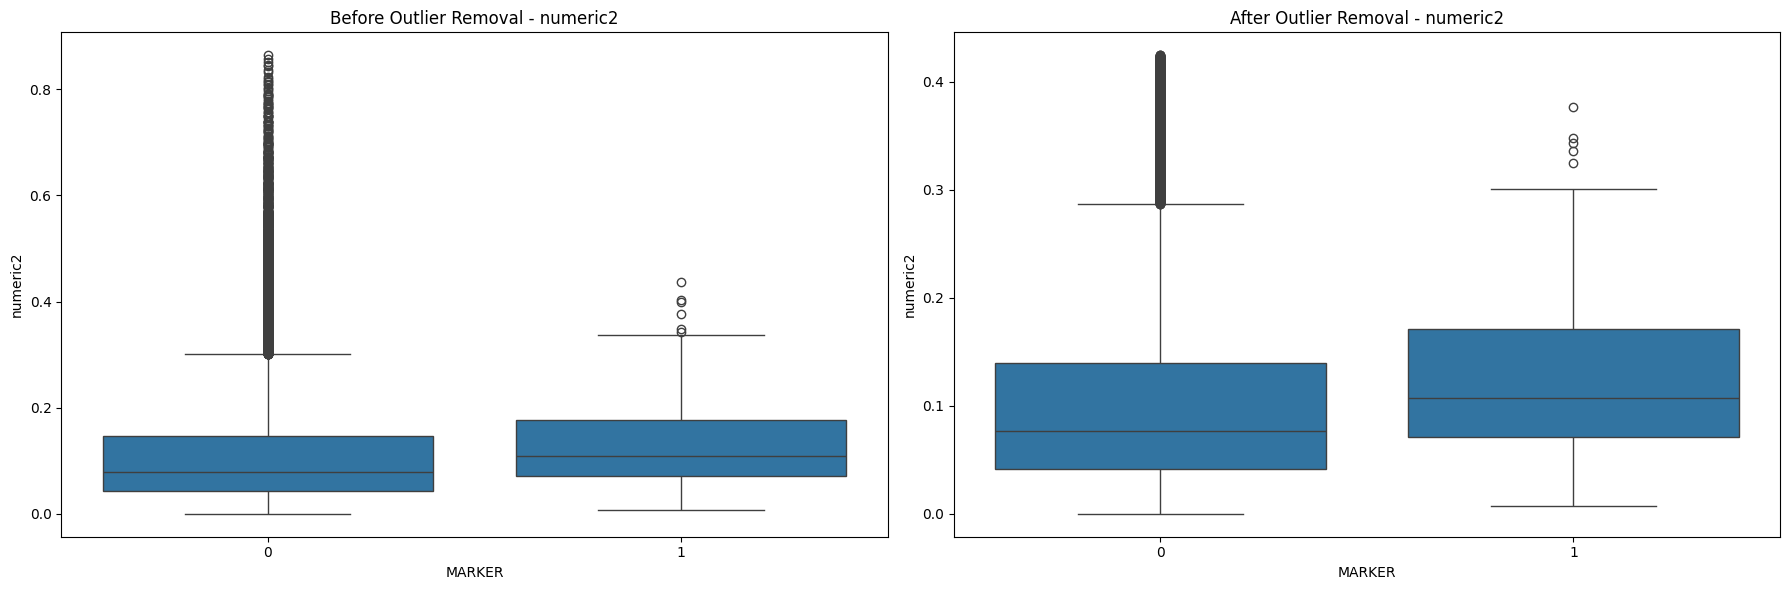

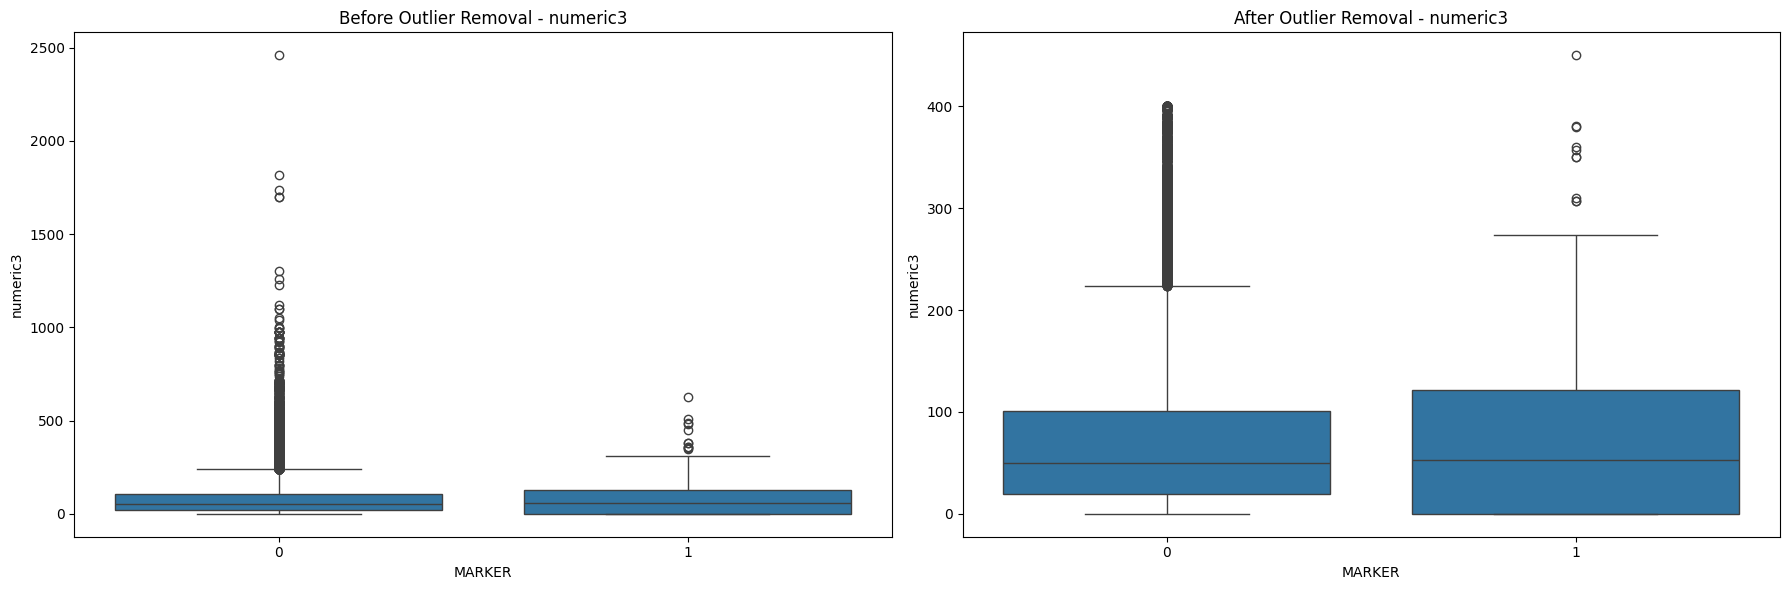

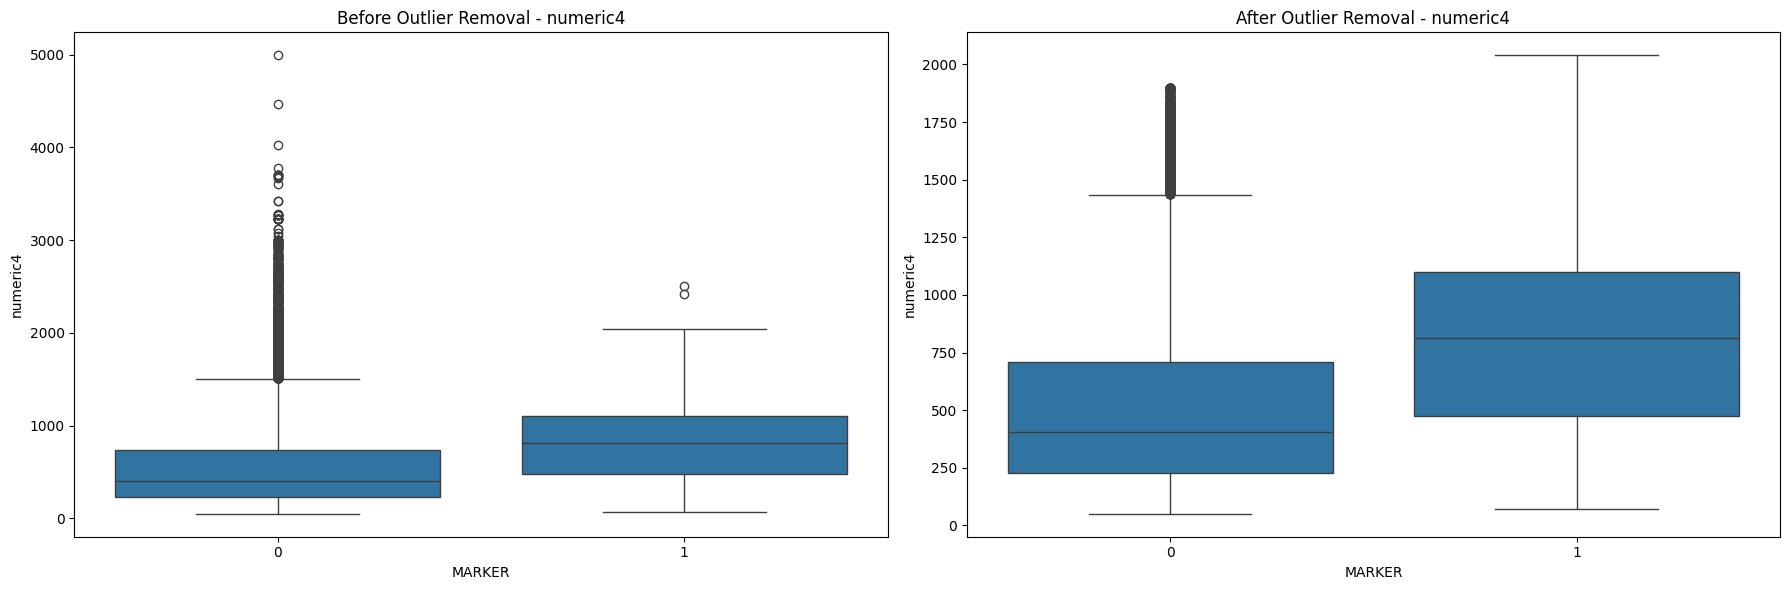

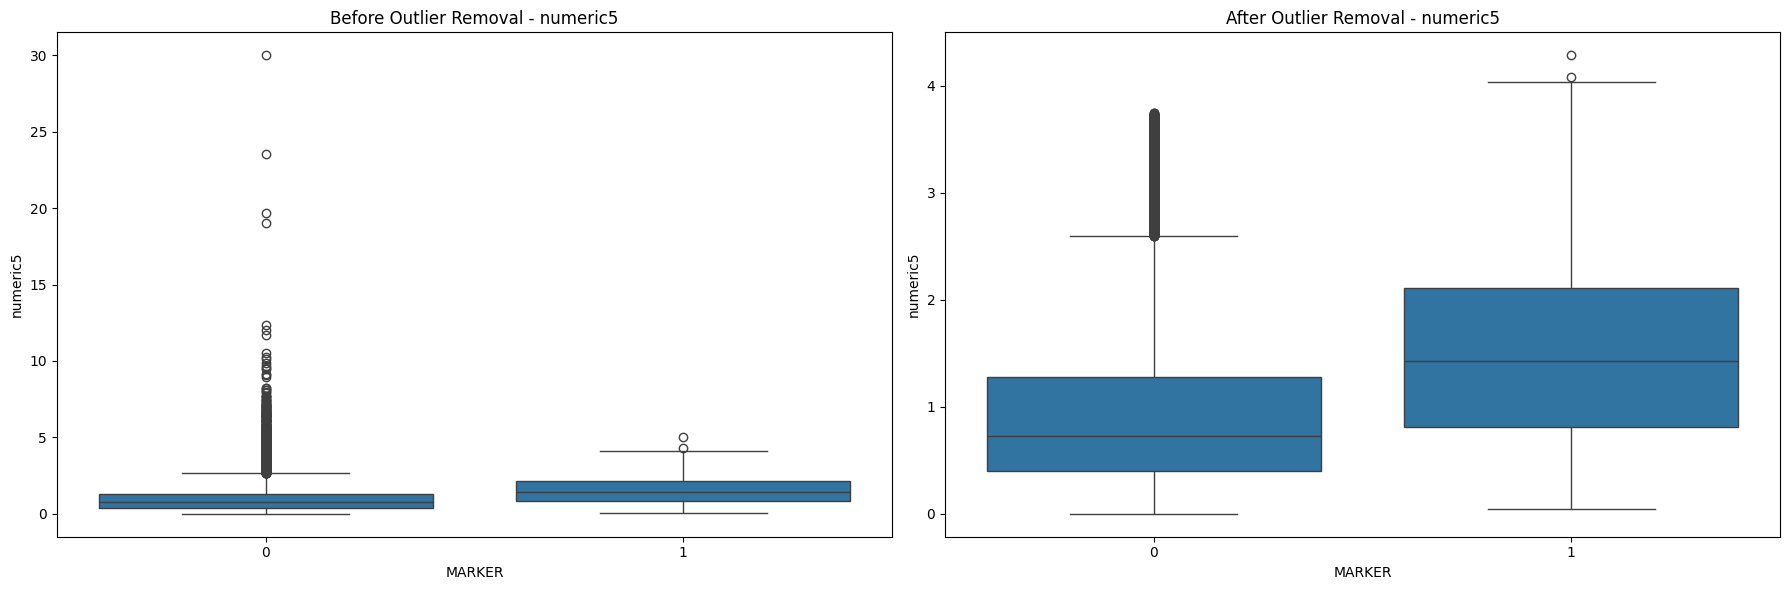

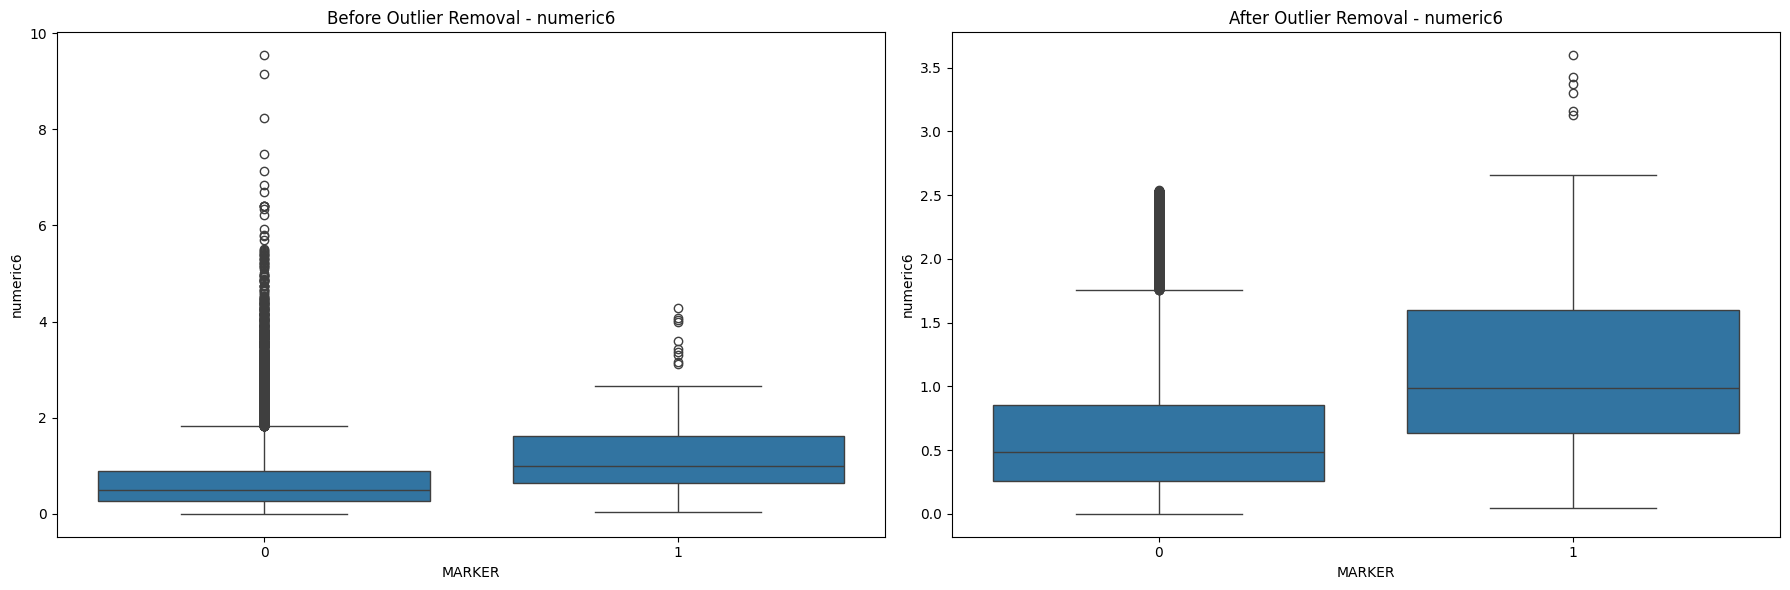

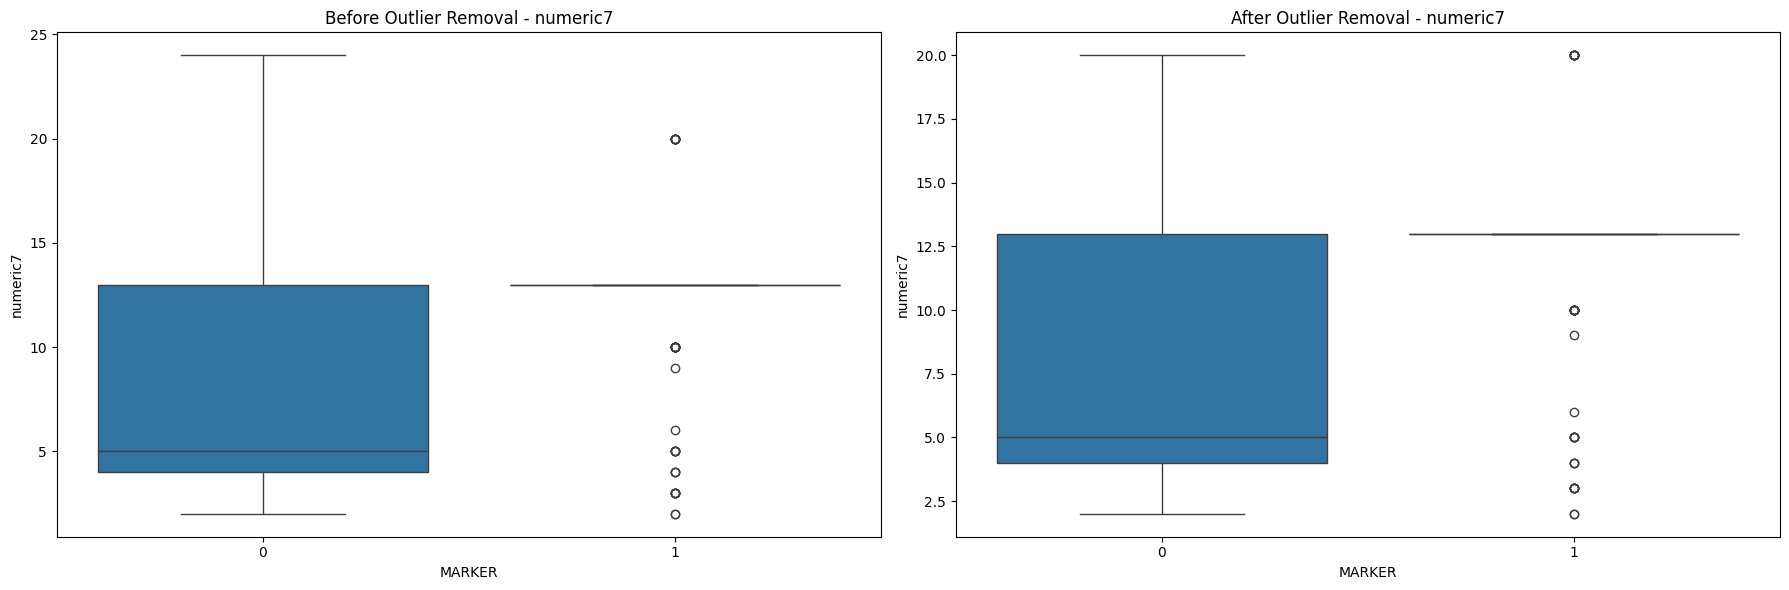

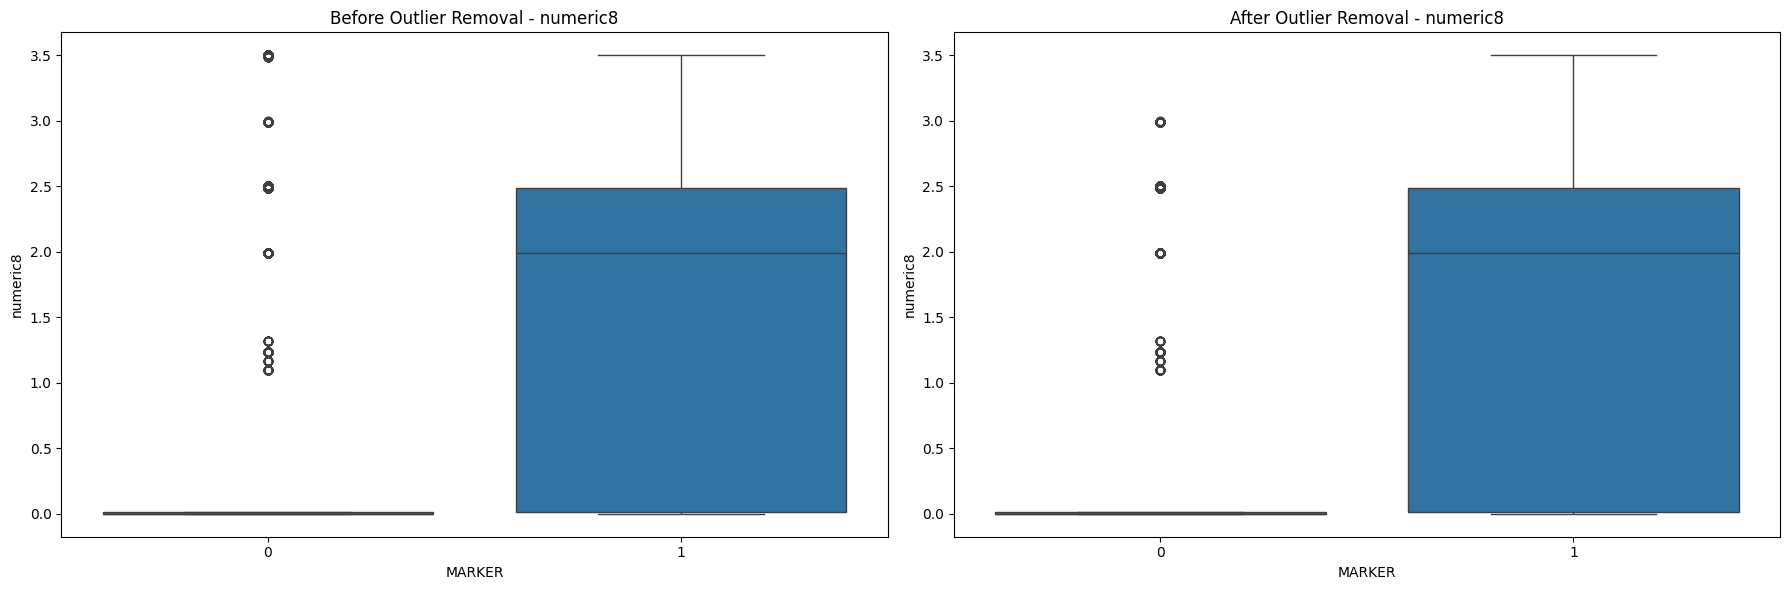

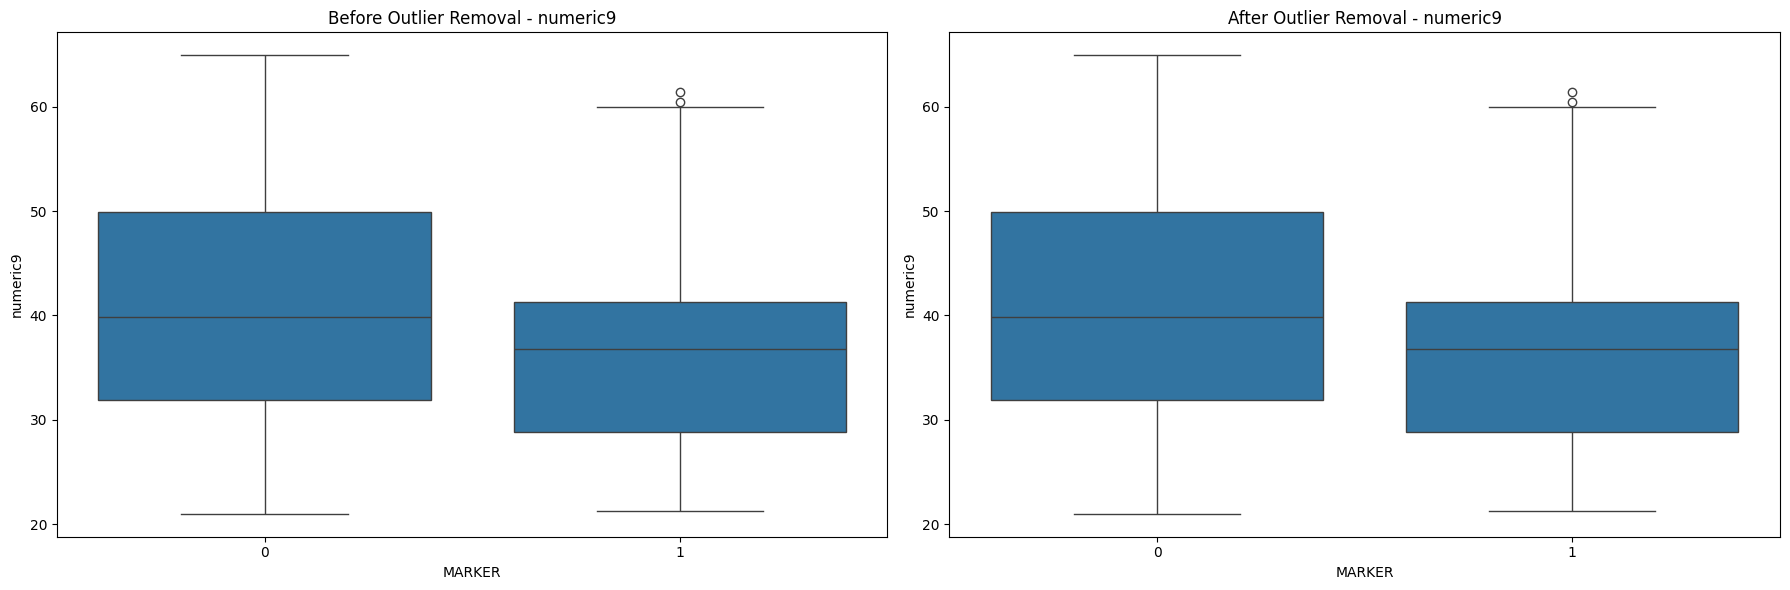

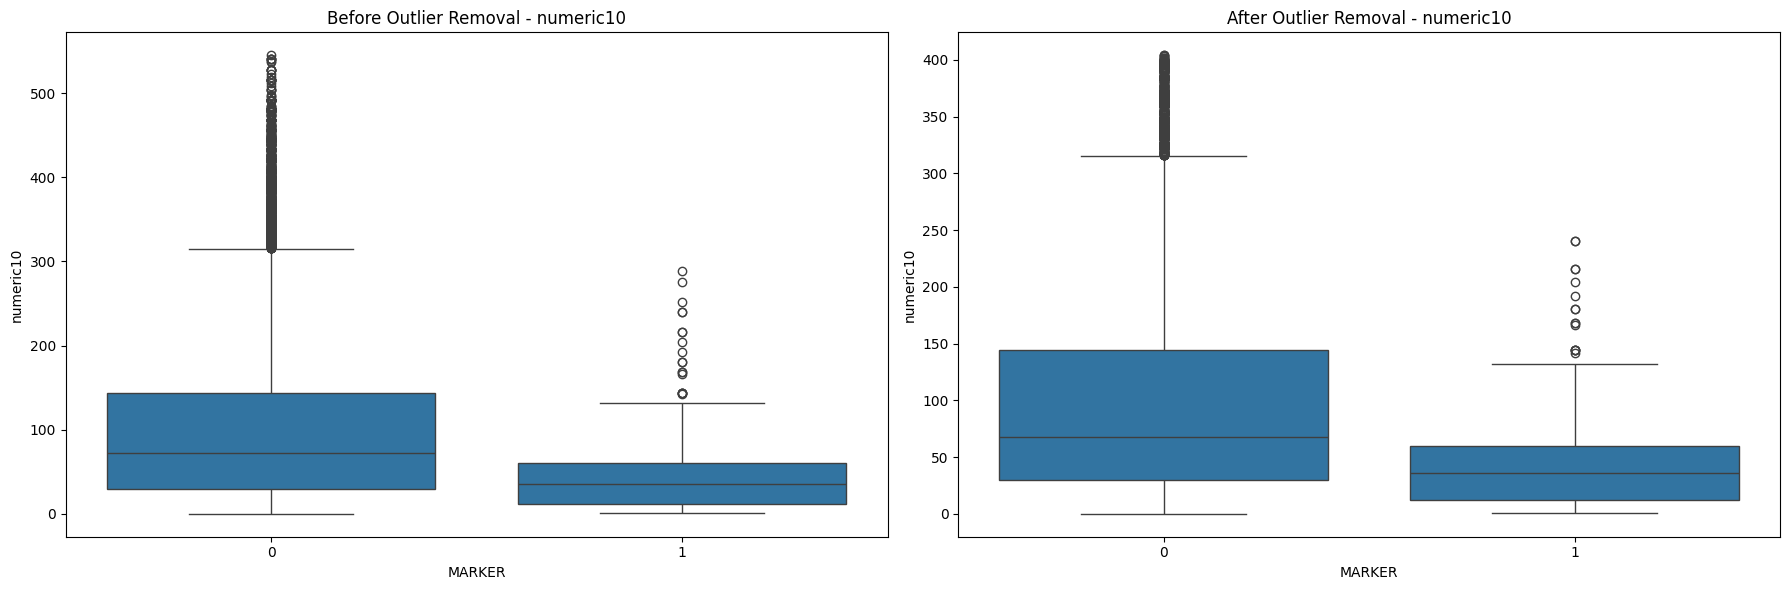

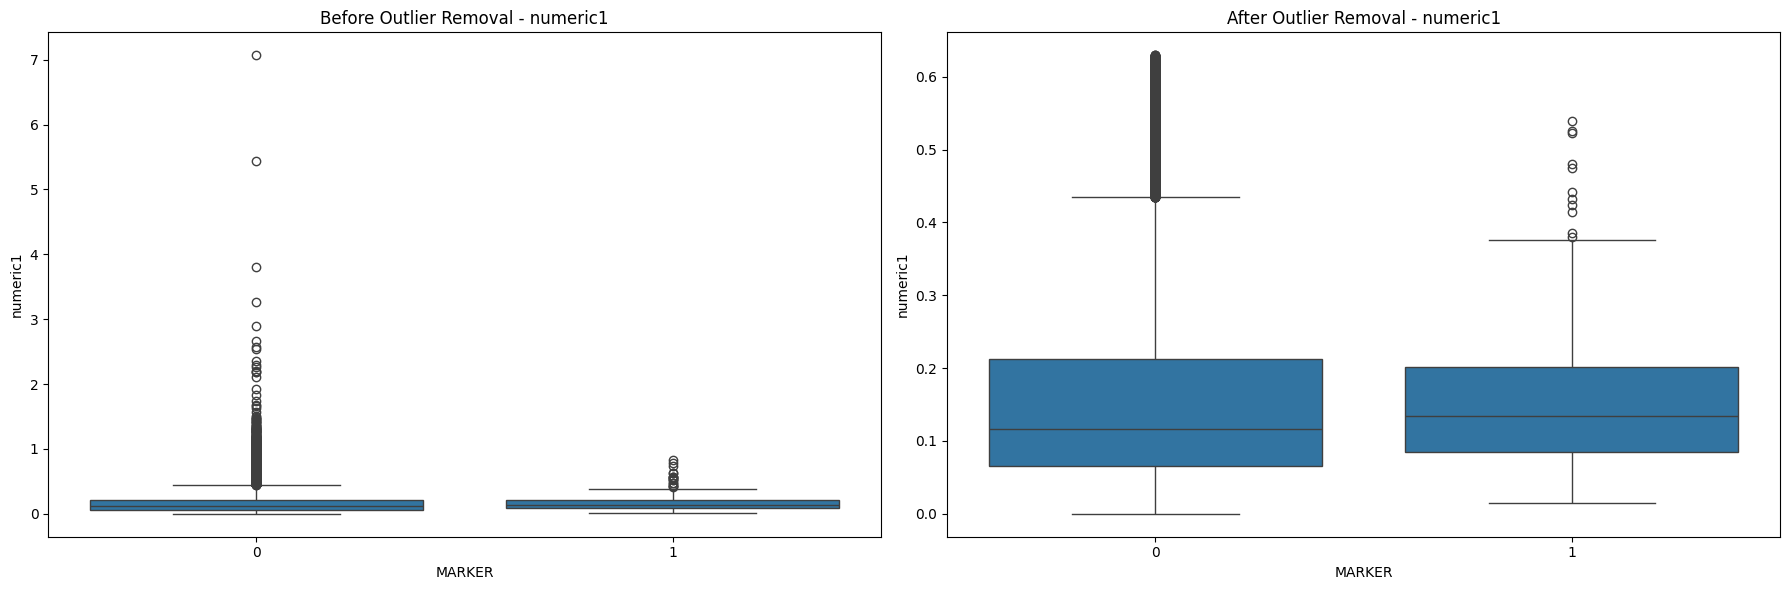

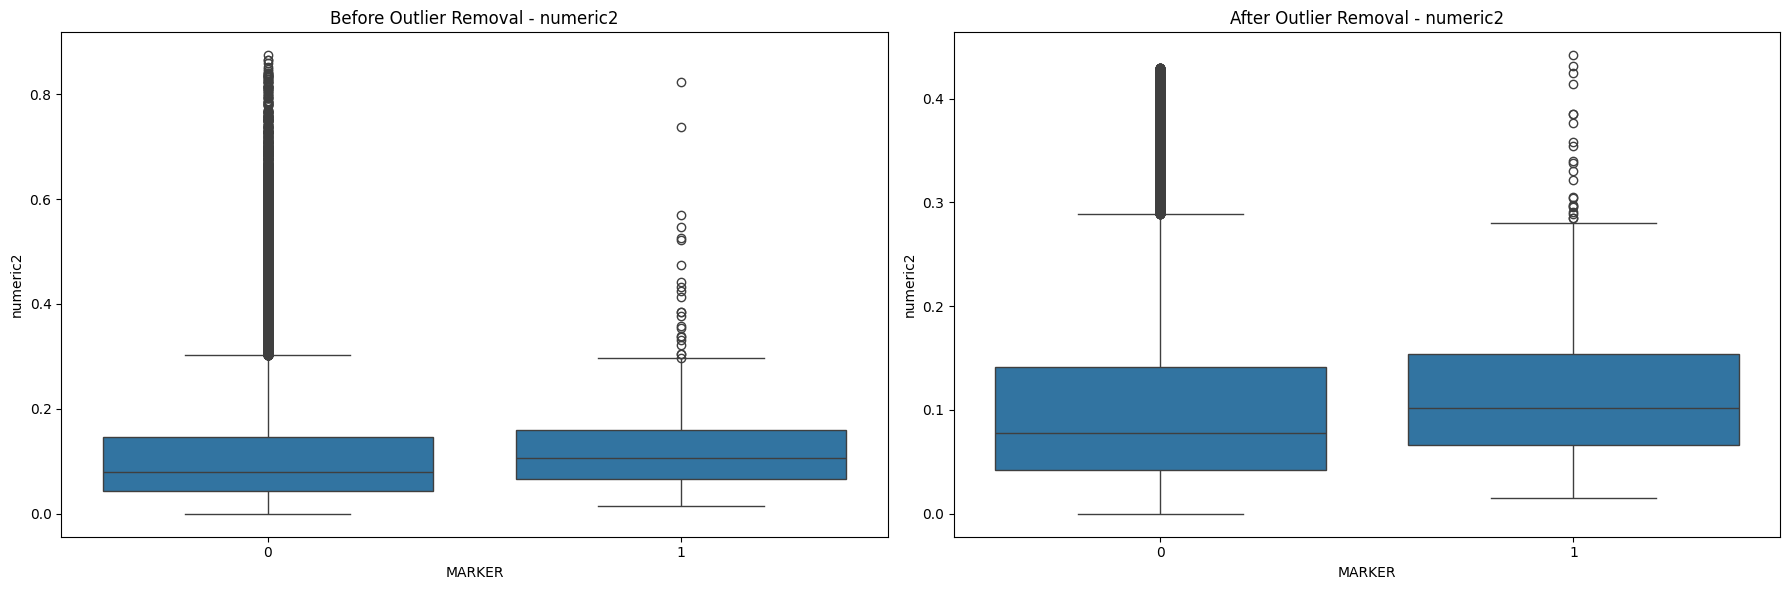

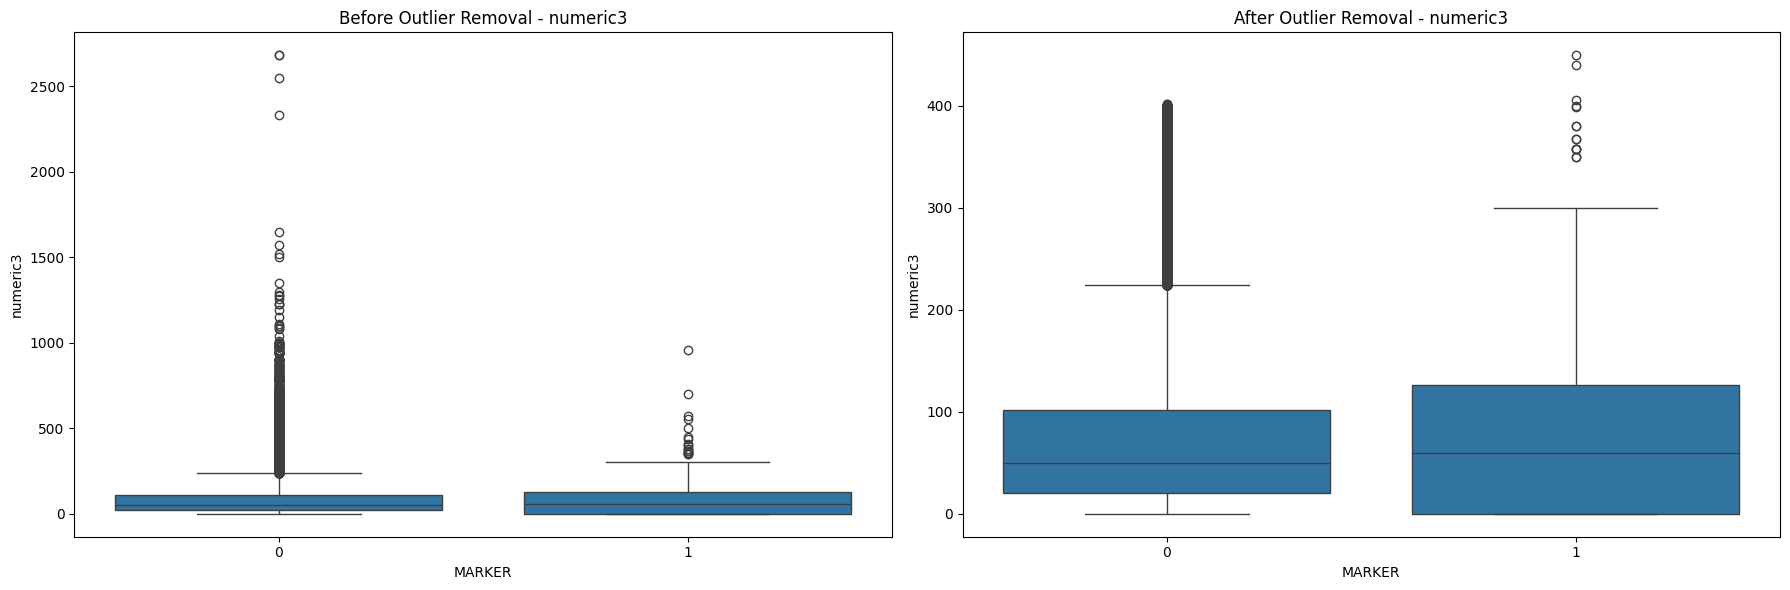

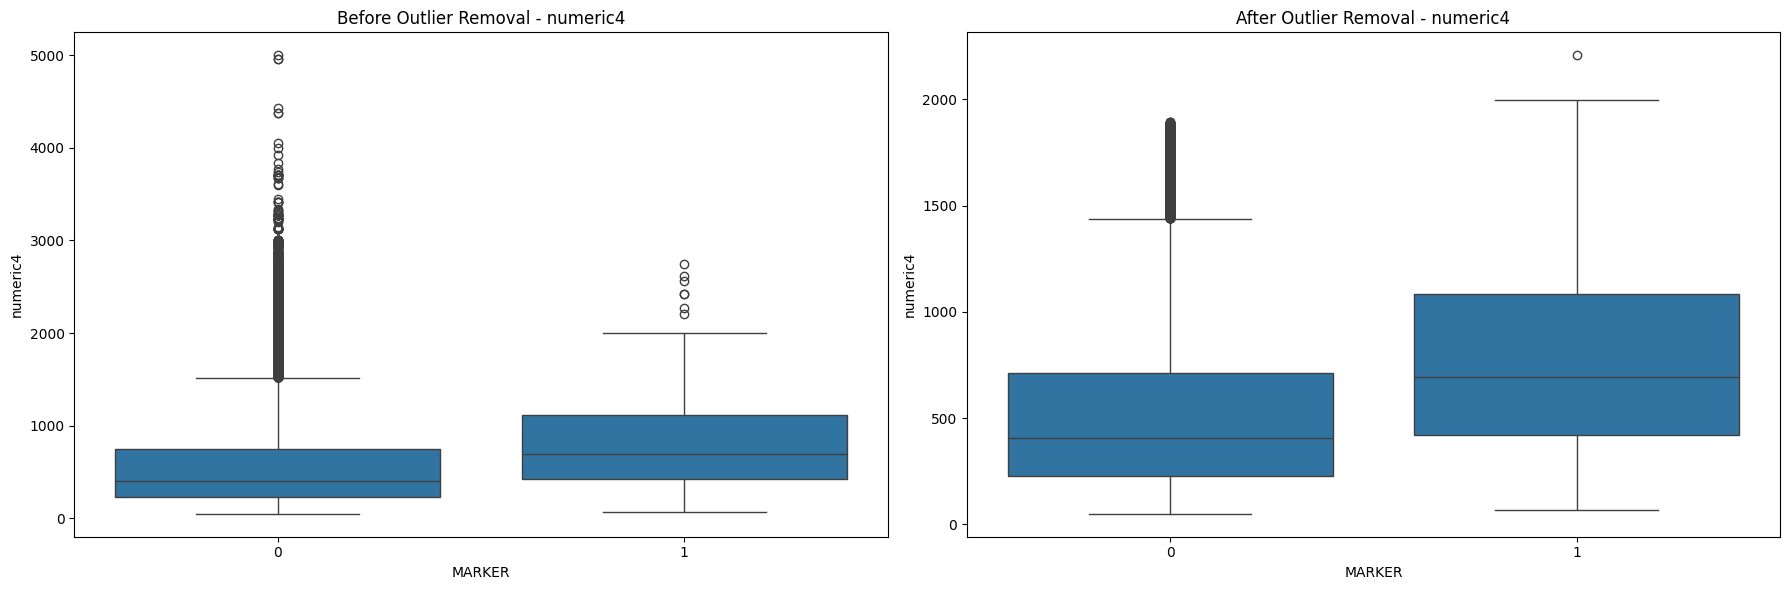

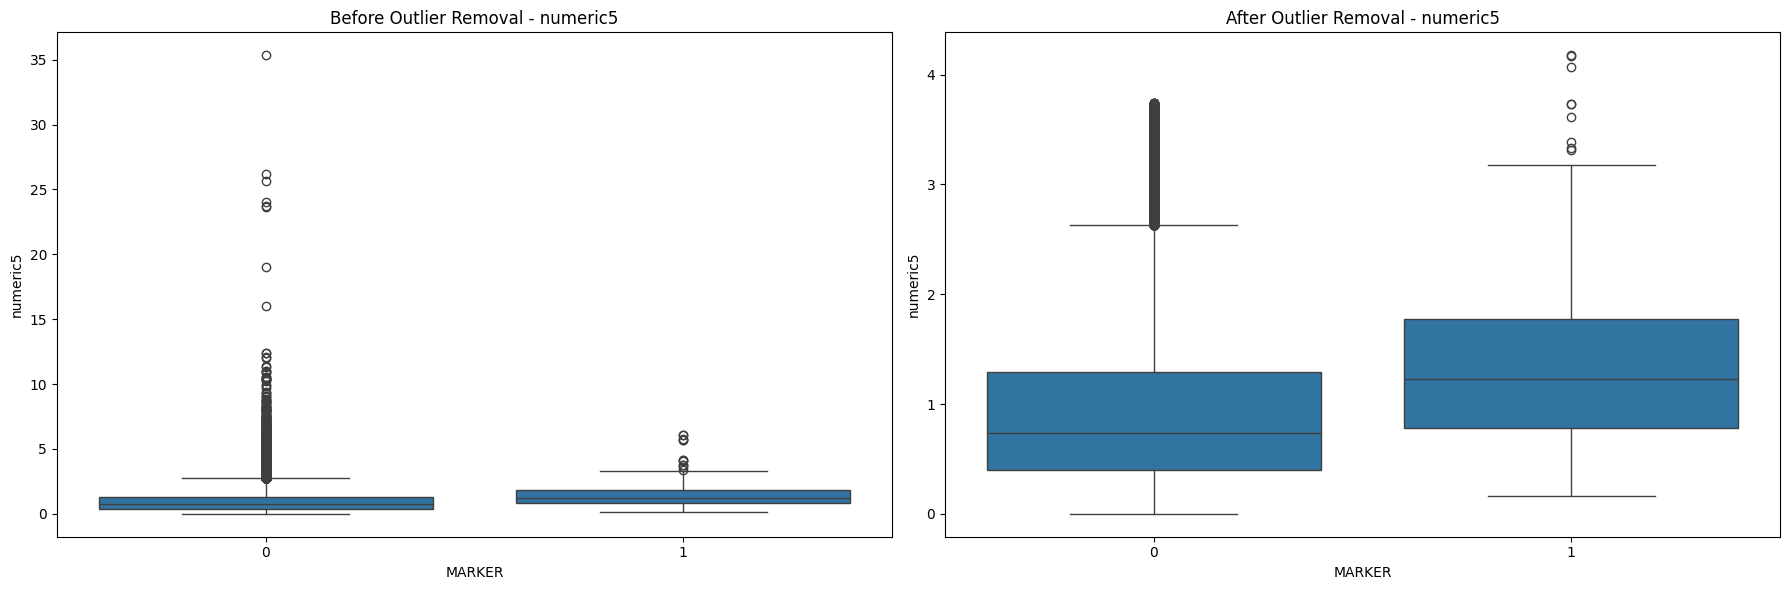

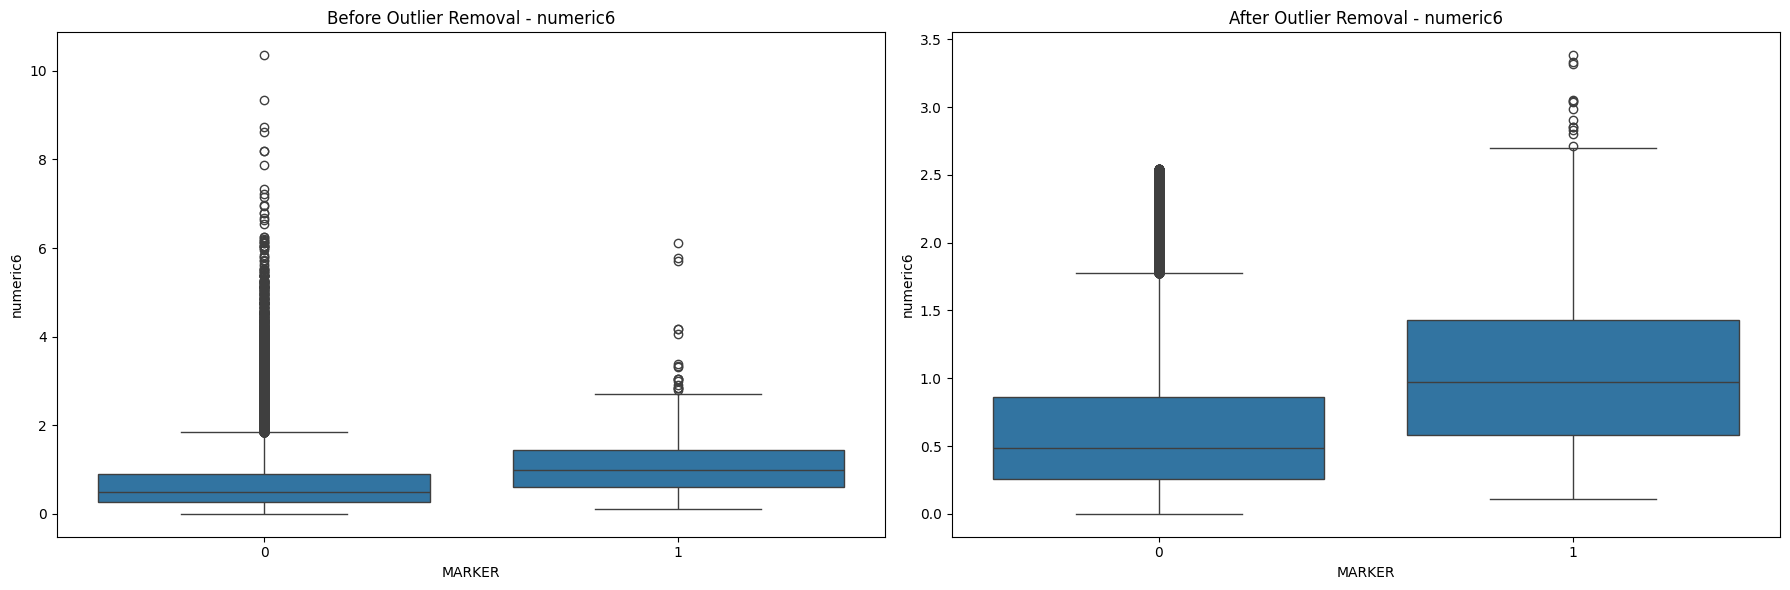

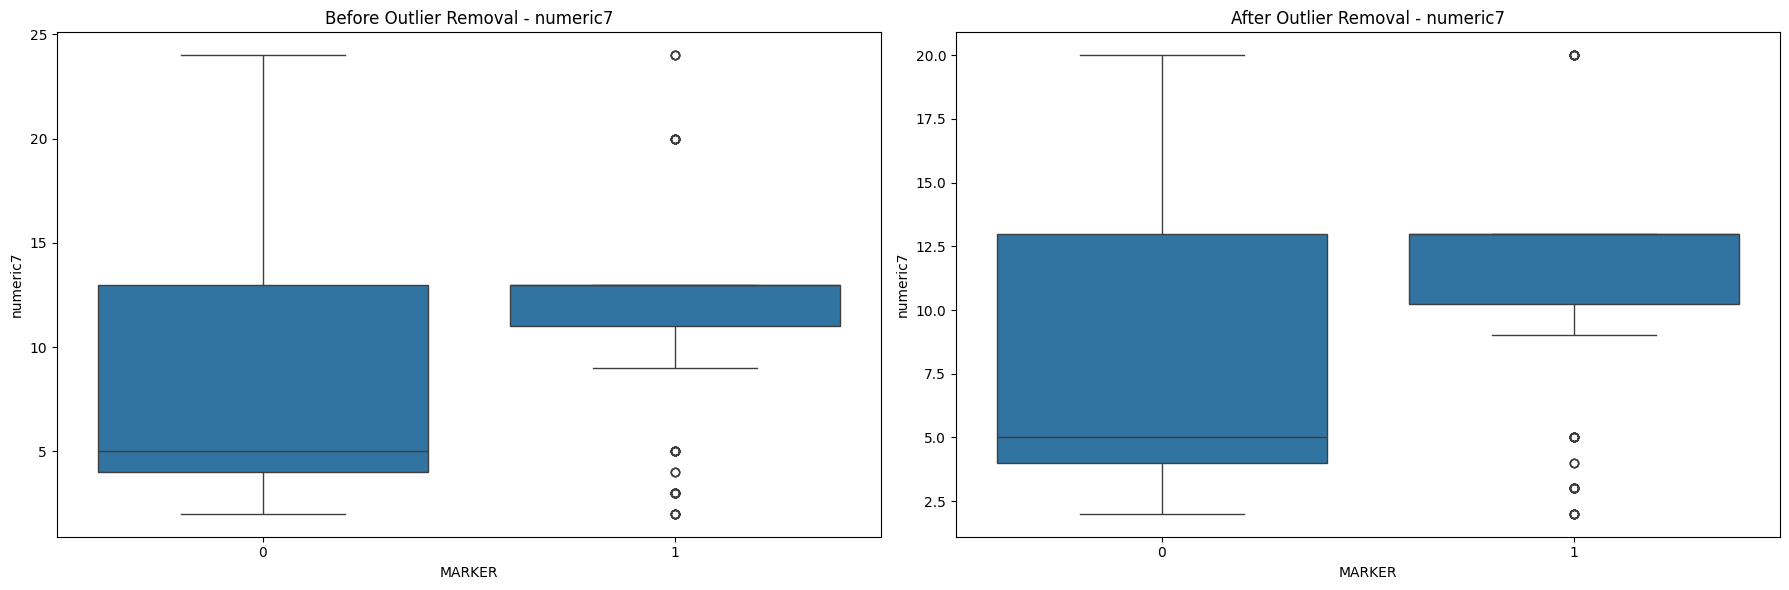

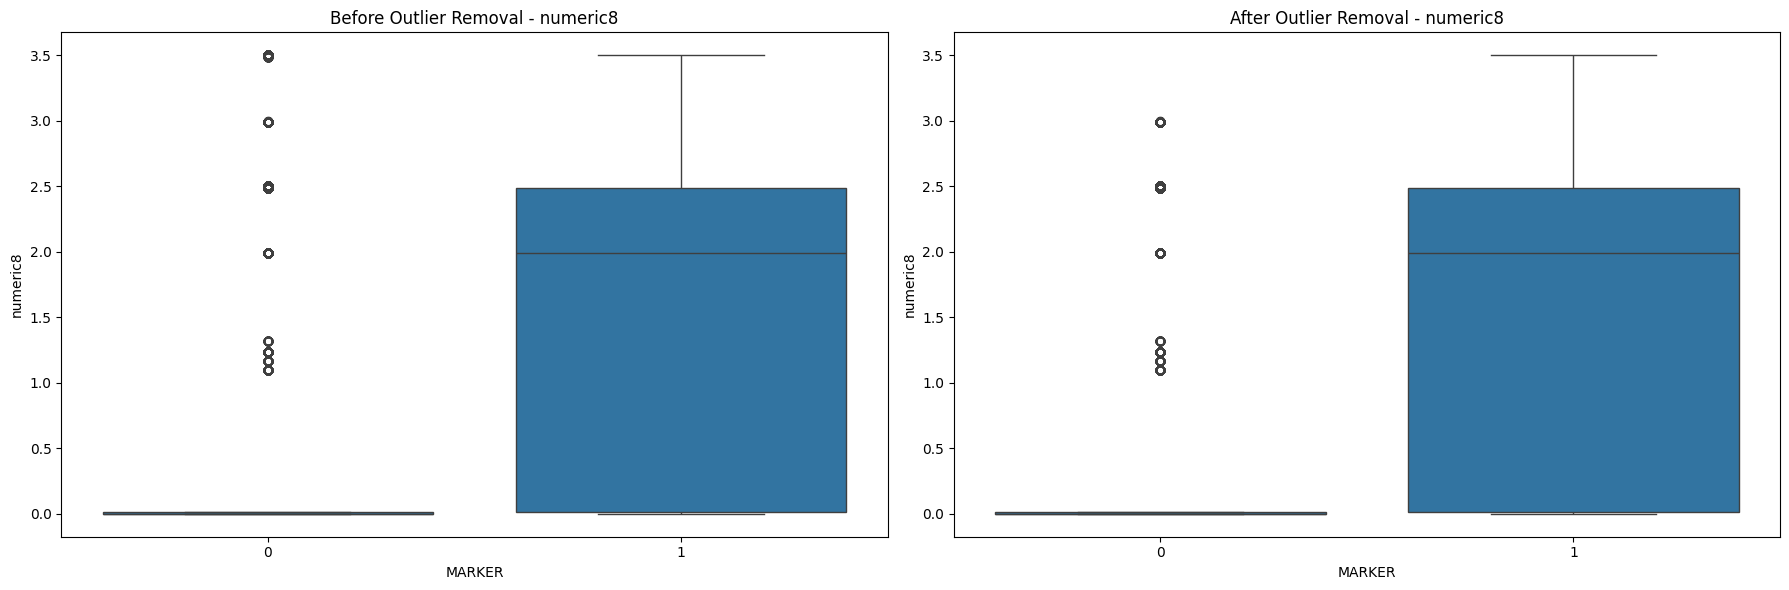

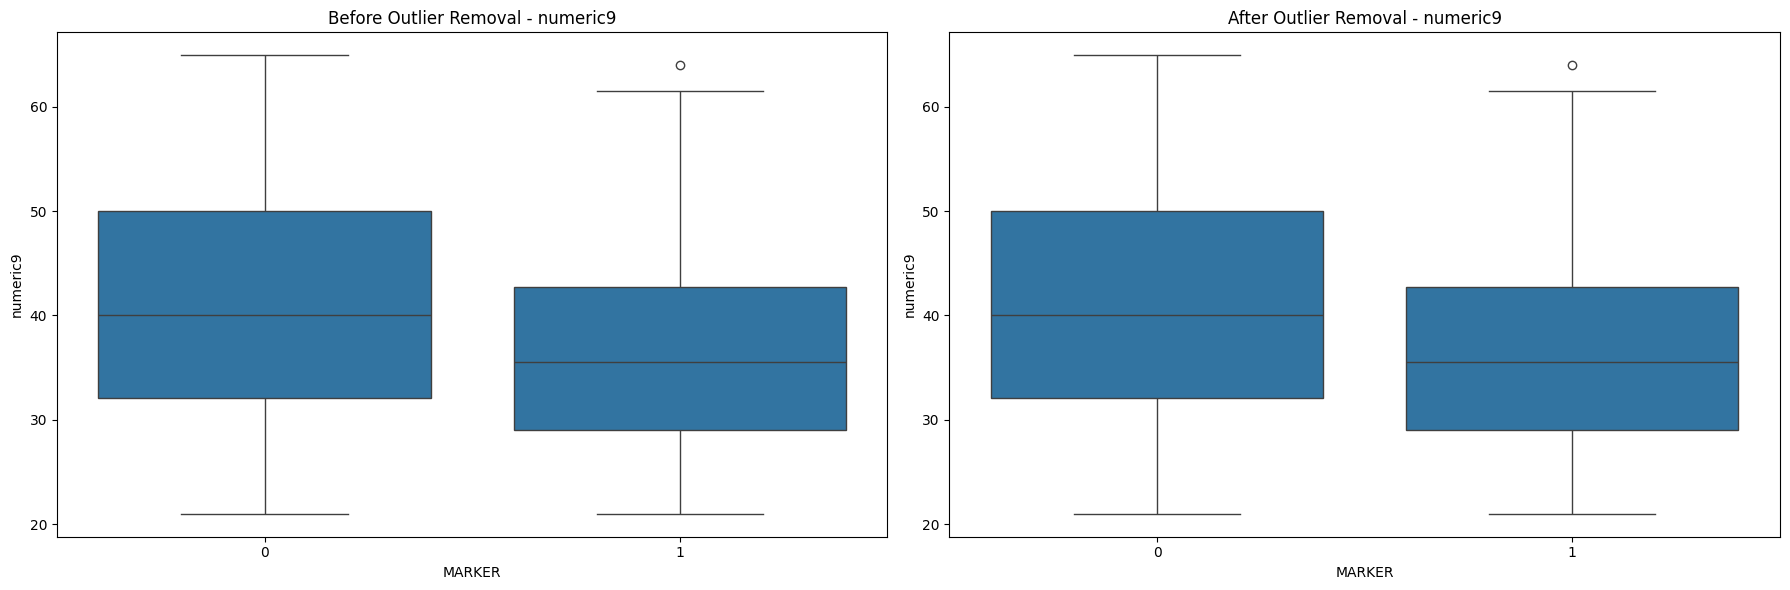

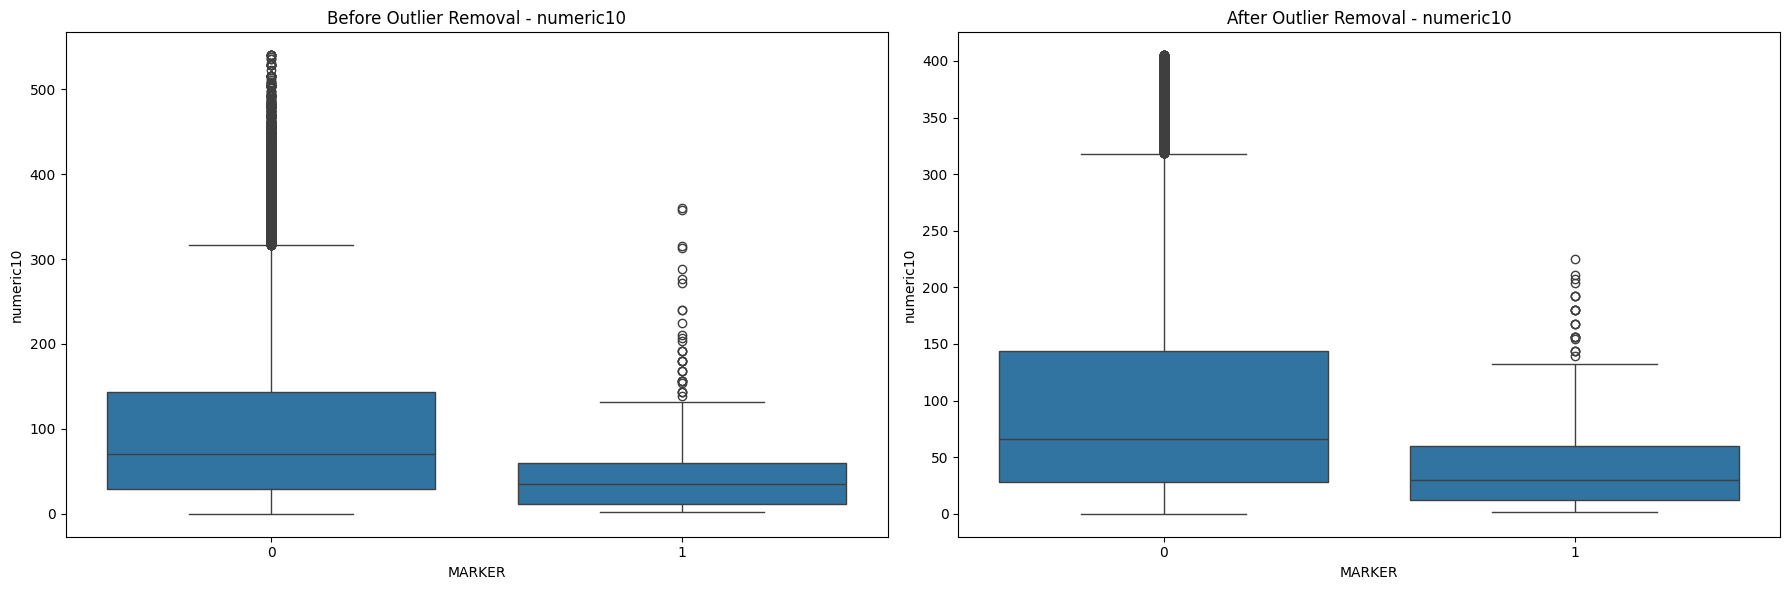

In [13]:
remove_outliers_visualization(data)

In [21]:
# # advanced filter

# def markov_probability_tresh(data, prob=0.03):
#     """
#         Parameters:
#          - data -> list of numerical values X_i >= 0
#          - prob -> probability, that occurence will exceed the threshold
         
#         Returns:
#          - thresh -> threshold, that satisfy P(x >= thresh; data) <= prob
#     """
#     assert len(list(filter(lambda el: el < 0.0, data))) == 0, "Series should satisfy non-negative value range"
    
#     data_mean = np.mean(data)
#     return data_mean / prob

# def remove_outliers(data):
#     to_filter = []
#     for df_name, df in data.items():
#         cols_to_filter = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['ID', 'MARKER']))].tolist()
#         #print(cols_to_filter)
#         candidates = [] 
#         for col in cols_to_filter:
#             candidates.append((df_name, col,))
#         to_filter.extend(candidates)
    
#     fig, axs = plt.subplots(1,len(to_filter), figsize=(18, 4))
#     for idx, (tbl, col) in enumerate(to_filter):
#         vals = list(filter(lambda x: x > 0, data[tbl][col].to_numpy().flatten()))
        
#         is_log = max(vals) - min(vals) > 1e3
        
#         sns.histplot(data=np.log10(vals) if is_log else vals, ax=axs[idx]).set_title(f'Histogram of {"log" if is_log else None}_{col} in {tbl}')
#         for perc in [0.01, 0.005, 0.001]:
#             print(f"[{tbl} | {col}] Markov thresh on {100 * perc}%: {markov_probability_tresh(vals, prob=perc)}")

## Выгрузка очищенных данных

In [15]:
%%time
# add path to load 
dirpath = os.getcwd()
path_to_load = Path(dirpath) / 'clean_data'
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in data.items():
    filepath = path_to_load / filename
    with open(filepath, mode='w', newline='') as file:
        df.to_csv(filepath, index=False)

CPU times: total: 1.33 s
Wall time: 1.37 s


In [16]:
# check for correct saving
print(*[f+"\n" for f in os.listdir(path_to_load) if os.path.isfile(os.path.join(path_to_load, f))])

Test
 Training

